### 1) Les équations

\begin{equation*}
\begin{cases}
\frac{d\text{Atmosphere}}{dt} &= (\text{PlantResp} + \text{SoilResp} + \text{Volcanoes} + \text{FossilFuelsCombustion} - \text{Photosynthesis} - \text{AtmOcExchange}) \\
\frac{d\text{CarbonateRock}}{dt} &= \text{Sedimentation} - \text{Volcanoes} \\
\frac{d\text{DeepOcean}}{dt} &= \text{Downwelling} - \text{Sedimentation} - \text{Upwelling} \\
\frac{d\text{FossilFuelCarbon}}{dt} &= -\text{FossilFuelsCombustion} \\
\frac{d\text{Plants}}{dt} &= \text{Photosynthesis} - \text{PlantResp} - \text{Litterfall} \\
\frac{d\text{Soils}}{dt} &= \text{Litterfall} - \text{SoilResp} \\
\frac{d\text{SurfaceOcean}}{dt} &= \text{Upwelling} + \text{AtmOcExchange} - \text{Downwelling} \\
\frac{d\text{VegLandArea\_percent}}{dt} &= -\text{Development}
\end{cases}
\end{equation*}

### Imports et fonction initiale

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
# Initial conditions
Atmosphere_Initial = 750
CarbonateRock_Initial = 100000000
DeepOcean_Initial = 38000
FossilFuel_Initial = 7500
Plant_Initial = 560
Soil_Initial = 1500
SurfaceOcean_Initial = 890
VegLandArea_percent_Initial = 100

x0 = np.array([Atmosphere_Initial,
               CarbonateRock_Initial,
               DeepOcean_Initial,
               FossilFuel_Initial,
               Plant_Initial,
               Soil_Initial,
               SurfaceOcean_Initial,
               VegLandArea_percent_Initial
               ])

In [ ]:
# Constants
Alk = 2.222446077610055
Kao = .278
SurfOcVol = .0362
Deforestation = 0

# Helper functions
def AtmCO2(Atmosphere):
    return Atmosphere * (280/Atmosphere_Initial)
def GlobalTemp(AtmCO2):
    return 15 + ((AtmCO2-280) * .01)
def CO2Effect(AtmCO2):
    return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
def WaterTemp(GlobalTemp):
    return 273+GlobalTemp
def TempEffect(GlobalTemp):
    return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
def SurfCConc(SurfaceOcean):
    return (SurfaceOcean/12000)/SurfOcVol
def Kcarb(WaterTemp):
    return .000575+(.000006*(WaterTemp-278))
def KCO2(WaterTemp):
    return .035+(.0019*(WaterTemp-278))
def HCO3(Kcarb, SurfCConc):
    return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
def CO3(HCO3):
    return (Alk-HCO3)/2
def pCO2Oc(KCO2, HCO3, CO3):
    return 280*KCO2*(HCO3**2/CO3)


# Fossil fuels
FossFuelData = np.array([[1850.0, 0.00], [1875.0, 0.30], [1900.0, 0.60], [1925.0, 1.35], [1950.0, 2.85], [1975.0, 4.95], [2000.0, 7.20], [2025.0, 10.05], [2050.0, 14.85], [2075.0, 20.70], [2100.0, 30.00]])
def FossilFuelsCombustion(t):
    i = 0
    if t >= FossFuelData[-1,0]:
        return FossFuelData[-1,1]
    while i + 1 < len(FossFuelData) and t >= FossFuelData[i,0]:
        i = i + 1
    if i == 0:
        return FossFuelData[0,1]
    else:
        return FossFuelData[i-1,1] + (t - FossFuelData[i-1,0]) / (FossFuelData[i,0] - FossFuelData[i-1,0]) * (FossFuelData[i,1] - FossFuelData[i-1,1])

def derivative(x, t):
    Atmosphere = x[0]
    CarbonateRock = x[1]
    DeepOcean = x[2]
    FossilFuelCarbon = x[3]
    Plants = x[4]
    Soils = x[5]
    SurfaceOcean = x[6]
    VegLandArea_percent = x[7]

    PlantResp = (Plants * (55/Plant_Initial)) + Deforestation/2
    Litterfall = (Plants* (55/Plant_Initial))+(Deforestation/2)
    SoilResp = Soils * (55/Soil_Initial)
    Volcanoes = 0.1
    AtmCO2_ = AtmCO2(Atmosphere)
    GlobalTemp_ = GlobalTemp(AtmCO2_)
    WaterTemp_ = WaterTemp(GlobalTemp_)
    Photosynthesis = 110 * CO2Effect(AtmCO2_) * (VegLandArea_percent/100) * TempEffect(GlobalTemp_)
    HCO3_ = HCO3(Kcarb(WaterTemp_), SurfCConc(SurfaceOcean))
    pCO2Oc_ = pCO2Oc(KCO2(WaterTemp_), HCO3_, CO3(HCO3_))
    AtmOcExchange = Kao*(AtmCO2_-pCO2Oc_)
    if x[3] > 0:
        FossilFuelsCombustion_ = FossilFuelsCombustion(t)
    else:
        FossilFuelsCombustion_ = 0
    dAtmosphere_dt = (PlantResp + SoilResp + Volcanoes + FossilFuelsCombustion_
                          - Photosynthesis - AtmOcExchange)

    Sedimentation = DeepOcean * (0.1/DeepOcean_Initial)
    dCarbonateRock_dt = Sedimentation - Volcanoes

    Downwelling = SurfaceOcean*(90.1/SurfaceOcean_Initial)
    Upwelling = DeepOcean * (90/DeepOcean_Initial)
    dDeepOcean_dt= Downwelling - Sedimentation - Upwelling

    dFossilFuelCarbon_dt = - FossilFuelsCombustion_

    dPlants_dt = Photosynthesis - PlantResp - Litterfall

    dSoils_dt = Litterfall - SoilResp

    dSurfaceOcean_dt = Upwelling + AtmOcExchange - Downwelling

    Development = (Deforestation/Plant_Initial * 0.2) * 100
    dVegLandArea_percent_dt = - Development

    derivative = np.array([
        dAtmosphere_dt,
        dCarbonateRock_dt,
        dDeepOcean_dt,
        dFossilFuelCarbon_dt,
        dPlants_dt,
        dSoils_dt,
        dSurfaceOcean_dt,
        dVegLandArea_percent_dt
        ])

    return derivative

### Methods Implementation

In [ ]:
# cette fonction est un peu nulle elle fait qu'une étape de Runge Kutta

# on reprend les notations du cours, avec c et b des lignes de longueur q et A une matrice q*q
# h est un reel
# (t, y(t)) -> f(t, y(t))
# tn est l'instant de début de l'étape
def runge_kutta_aux(f, tn, yn, c, b, A, hn):
  q = len(c)
  t = tn + hn*c
  y = np.zeros((q, len(yn)))
  p = np.zeros((q, len(yn)))
  for i in range(0, q):
    y[i, :] = yn + hn * sum(A[i,:] @ p) # notation fonctionne parce que les p sont initialisés à 0
    p[i, :] = f(y[i,:], t[i])
  return yn + hn * (b.T @ p)

# runge-kutta complet
# h est un tableau. Avec t0 il permet d'avoir tt l'intervalle.
def runge_kutta(f, t0, y0, c, b, A, h):
  N = len(h)
  t = np.array([t0 + sum(h[:i]) for i in range(0, N)])
  y = np.zeros((N + 1, len(y0)))
  y[0,:] = y0
  for j in range(0, N):
    y[j+1, :] = runge_kutta_aux(f, t[j], y[j,:], c, b, A, h[j])
  return y[:-1]

In [ ]:
def euler(x0, t0, h):
    N = len(h)
    t = np.array([t0 + sum(h[:i]) for i in range(0, N)])
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        x[i] = x[i-1] + h[i] * derivative(x[i-1], t[i-1])
    return x

### Plot functions

In [ ]:
#Vrai fonction pour plot, la premiere plot features par features, l'autre plot comme sur le site
def plot_method(y, t , label=['Atmosphere', 'CarbonateRock', 'DeepOcean', 'FossilFuel', 'Plant', 'Soil', 'SurfaceOcean', 'VegLandArea_percent']):
    num_plots = len(label)
    num_cols = 3  # Nombre de colonnes (2 images par ligne)
    num_rows = 3 # Arrondi supérieur pour le nombre de lignes

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))  # Crée une grille de sous-graphiques

    # Tracer chaque sous-graphique
    for i, ax in enumerate(axs.flat):
        if i < num_plots:
            ax.plot(t, y[:, i])
            ax.set_title(label[i])
            ax.grid()

    # Supprimer les axes non utilisés
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axs.flatten()[i])

    plt.tight_layout()
    plt.show()

def plot_method1(y, t, label=np.array(['Atmosphere', 'CarbonateRock', 'DeepOcean', 'FossilFuel', 'Plant', 'Soil', 'SurfaceOcean', 'VegLandArea_percent'])):
    num_plots = len(label)

    colors = ['b', 'b', 'purple', 'r', 'g', 'orange', 'orange', 'g']
    list_1=[0,2,3,4,5]

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(11, 8))  # Ajuster la taille de la figure horizontalement
    handles1 = []
    handles2=[]
    j=0
    # Tracer chaque fonction sur un axe y séparé avec sa propre couleur et échelle
    for i in range(num_plots):
        if i in list_1:
            ax = ax1.twinx()
            line, =ax.plot(t, y[:, i], color=colors[i], label=label[i])
            ax.set_ylabel(label[i], color=colors[i])  # Définir la couleur du label de l'axe y
            ax.tick_params(axis='y', colors=colors[i])  # Définir la couleur des graduations de l'axe y
            ax.spines['right'].set_position(('outward', (i-j) * 50))
            handles1.append(line)
        else:
            ax = ax2.twinx()
            line, =ax.plot(t, y[:, i], color=colors[i], label=label[i])
            ax.set_ylabel(label[i], color=colors[i])  # Définir la couleur du label de l'axe y
            ax.tick_params(axis='y', colors=colors[i])  # Définir la couleur des graduations de l'axe y
            ax.spines['right'].set_position(('outward', j * 50))
            handles2.append(line)
            j+=1

    ax1.set_xlabel('Years')
    ax2.set_xlabel('Years')
    plt.title('Evolution of the different components of the carbon cycle')

    # Gérer la légende en haut à gauche
    ax1.legend(handles1, label[list_1], loc='upper left')
    ax2.legend(handles2, label[[1,6,7]], loc='upper left')
    ax1.set_yticklabels([])

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_runge_comp(y_l, t, label2 ,label = ['Atmosphere', 'CarbonateRock', 'DeepOcean', 'FossilFuel', 'Plant', 'Soil', 'SurfaceOcean', 'VegLandArea_percent']):
    for i in range(0, len(y_l[0, 0, :])):
        for j in range(0, len(y_l)):
            plt.plot(t, y_l[j,:,i], label = label2[j])
            plt.legend()
        plt.grid()
        plt.title(label[i])
        plt.show()


### Plot des exemples

#### Euler and RK1 (= euler)

In [ ]:
# des tests
c1 = np.array([0])
b1 = np.array([1])
A1 = np.array([[0]])

t0 = 1800 # les emissions commencent autour des années 1900 (cf la fonction plus haut)
T = 800 # on simule sur 800 ans
n = T*10
h = [T/n for i in range(0, n)]
t = np.array([t0 + i * T/n for i in range(0, n)])

y = runge_kutta(derivative, t0, x0, c1, b1, A1, h)
y_runge_kutta = runge_kutta(derivative, t0, x0, c1, b1, A1, h)
y_euler = euler(x0, t0, h)

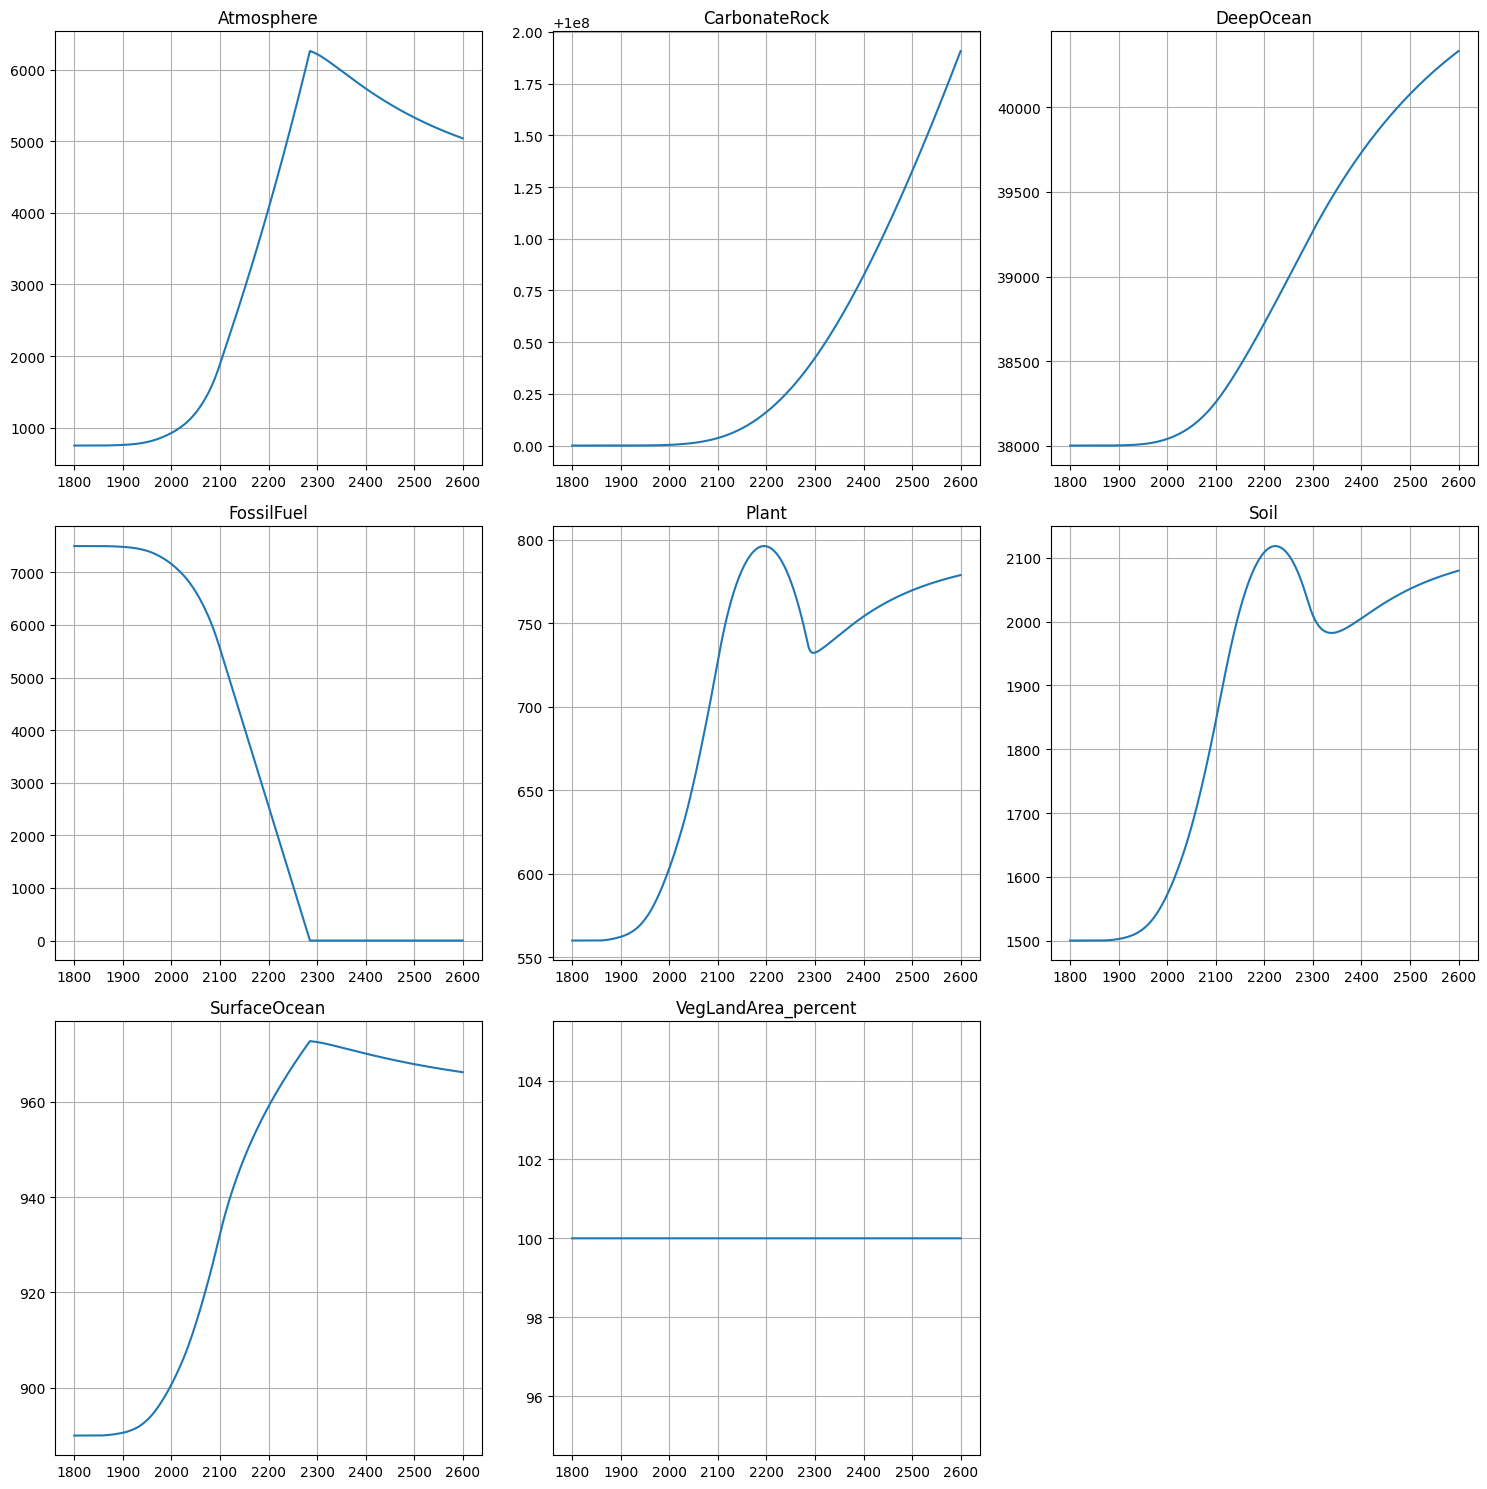

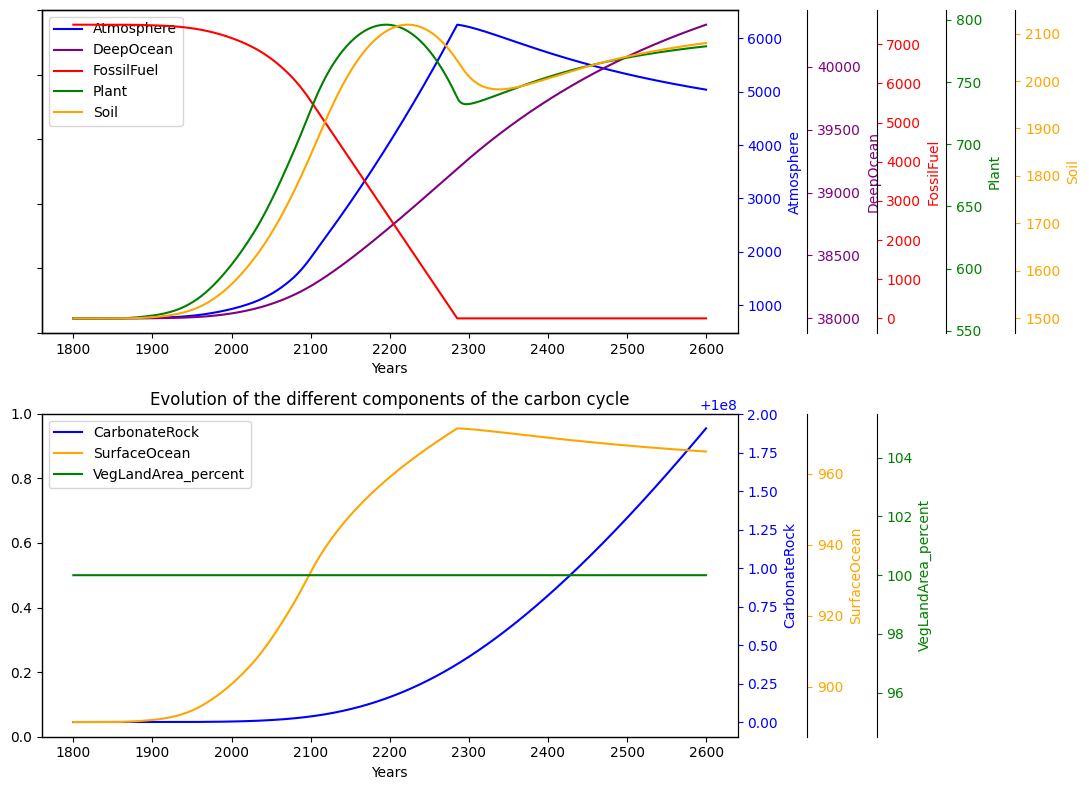

In [ ]:
plot_method(y_euler,t)
plot_method1(y_euler, t)

In [ ]:
print("Norme de la difference entre les deux méthodes : ", np.linalg.norm(y_euler - y_runge_kutta))

Norme de la difference entre les deux méthodes :  0.0


#### RK2

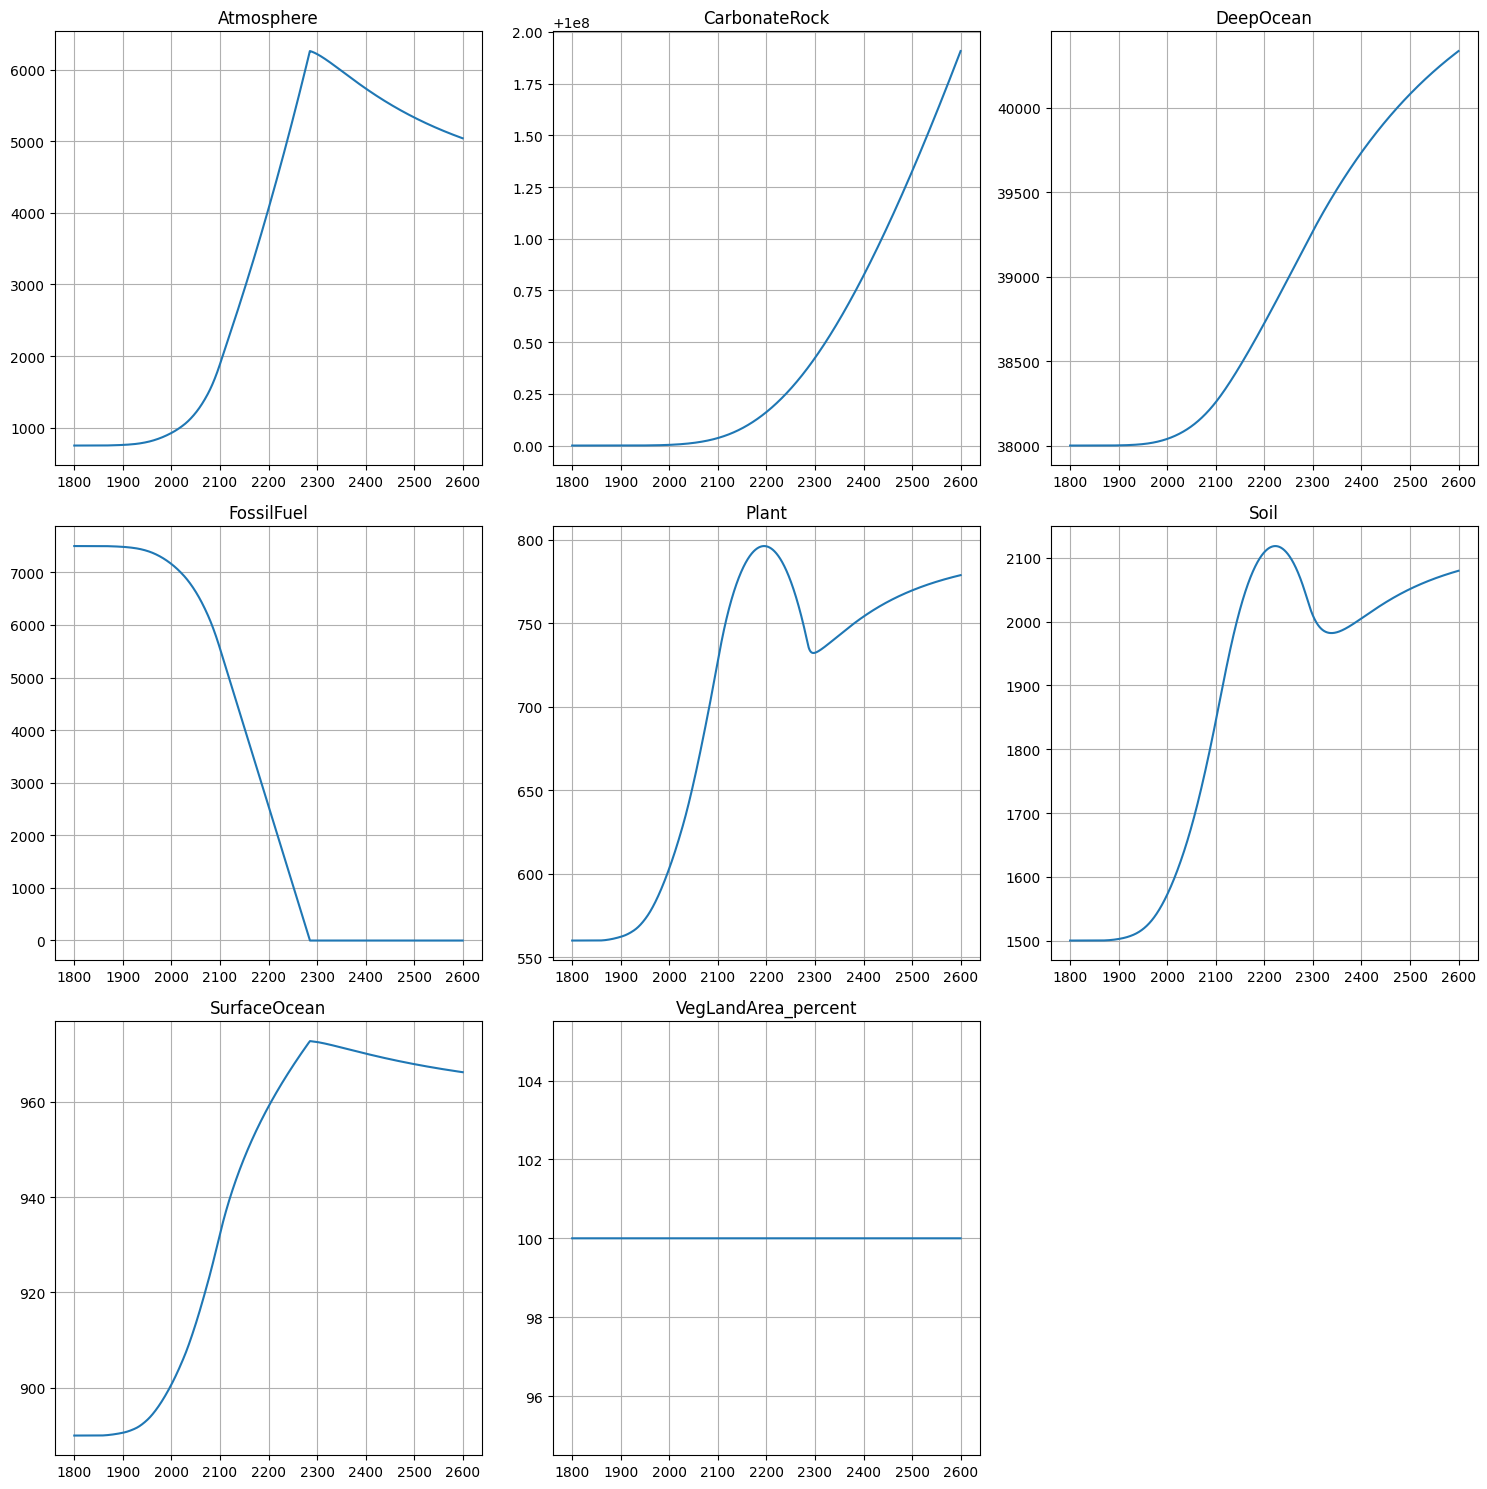

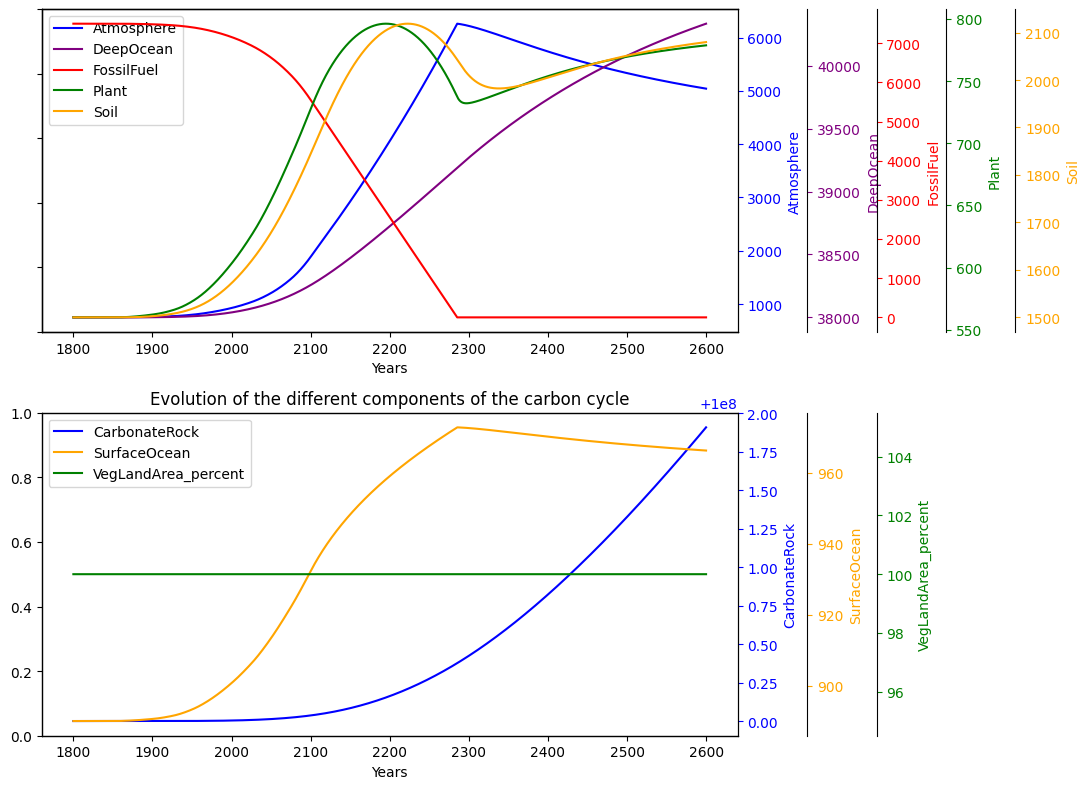

In [ ]:
#RK with q=2
#We choose those constant to have method od order 2
c2 = np.array([0, 0.5])
b2 = np.array([0, 1])
A2 = np.array([[0, 0],
               [0.5, 0]])

t0 = 1800
T = 800
n = T*10
h = [T/n for i in range(0, n)]
t = np.array([t0 + i * T/n for i in range(0, n)])

y_RK2 = runge_kutta(derivative, t0, x0, c2, b2, A2, h)
plot_method(y_RK2,t)
plot_method1(y_RK2,t)

#### RK4

In [ ]:
# on fait des tests avec q = 4
#Classique RK4 -> Methode d'ordre 4
c4 = np.array([0, 0.5, 0.5, 1])
b4 = np.array([1/6, 1/3, 1/3, 1/6])
A4 = np.array([[0,0,0,0],
               [0.5, 0, 0, 0],
               [0, 0.5, 0, 0],
               [0, 0, 1, 0]])
t0 = 1800
T = 800
n = T*10 #10 points par an
h = [T/n for i in range(0, n)]
t = np.array([t0 + i * T/n for i in range(0, n)])

y_RK4 = runge_kutta(derivative, t0, x0, c4, b4, A4, h)

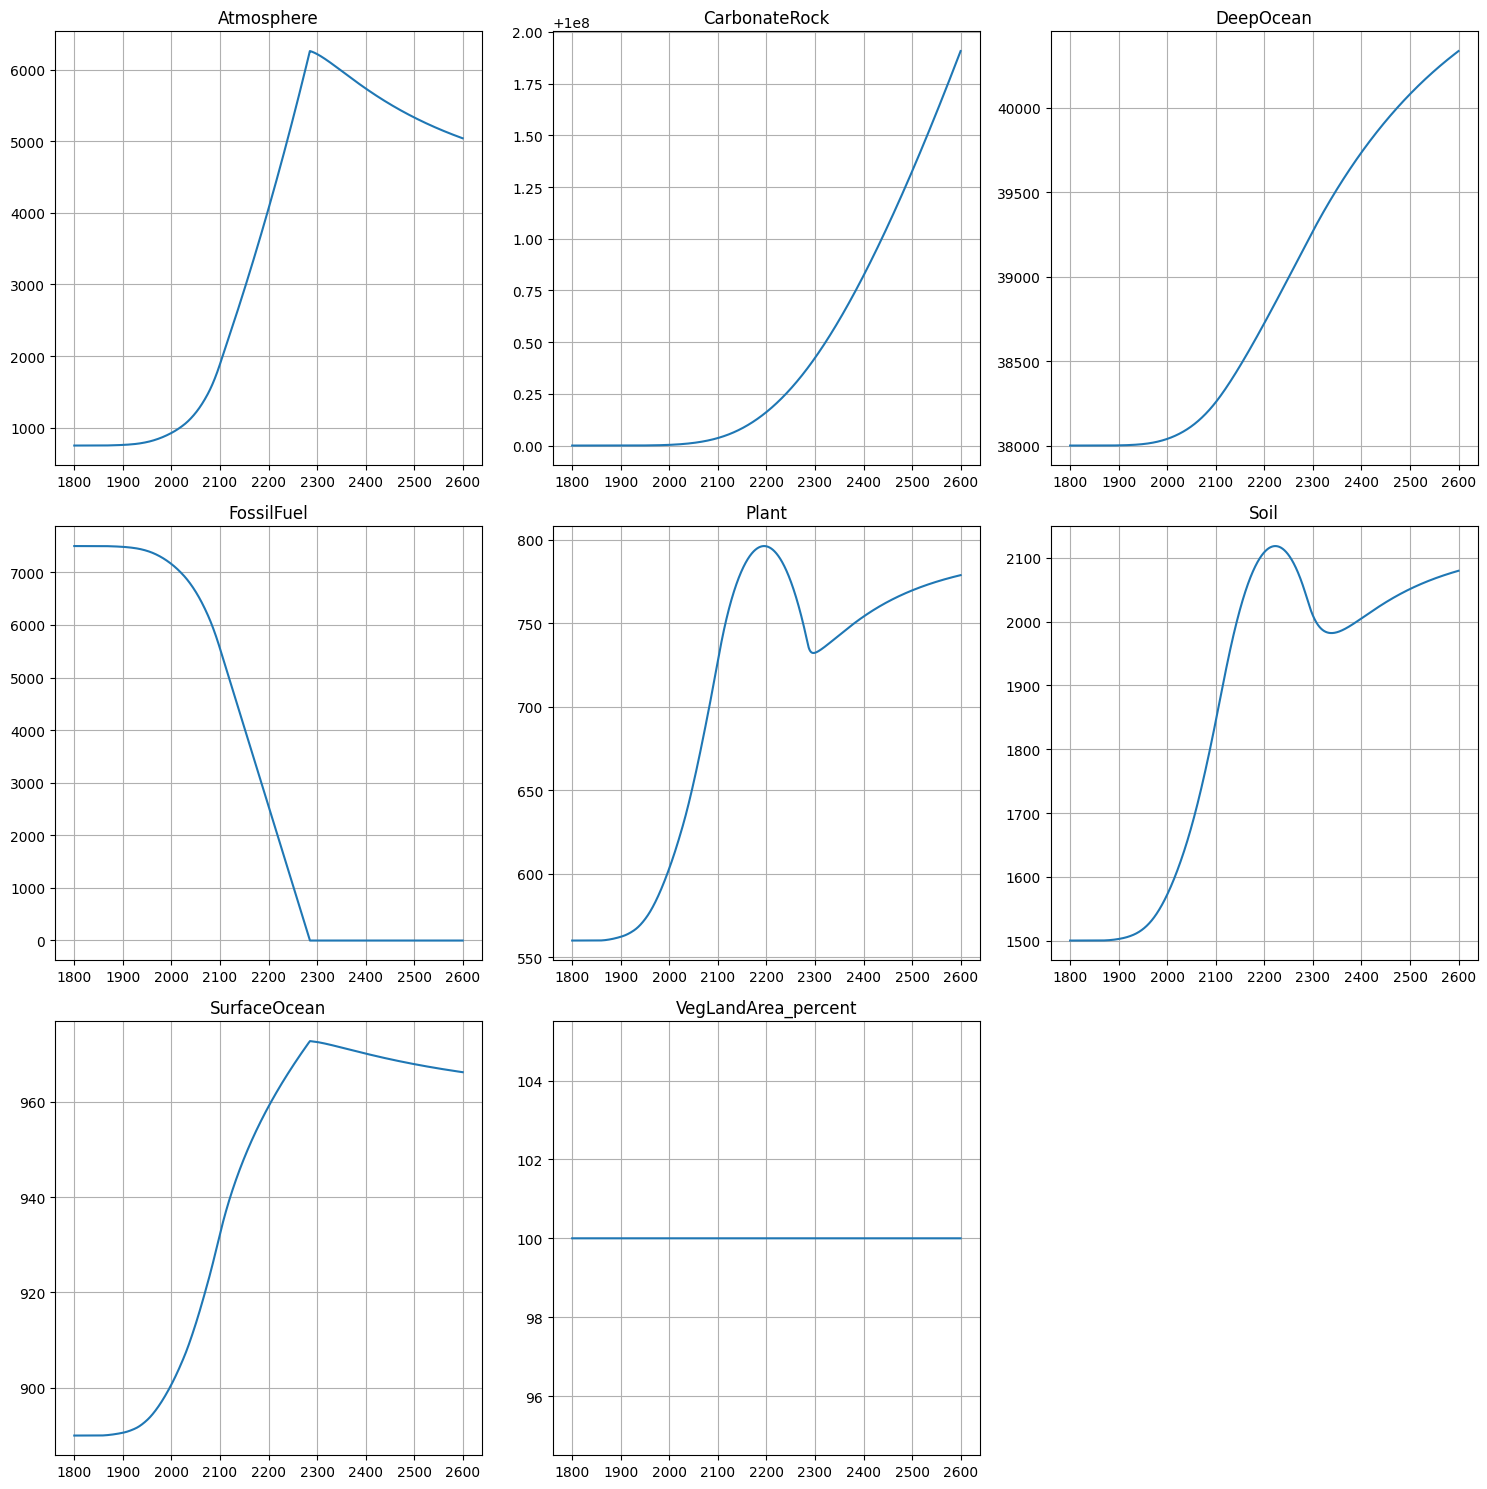

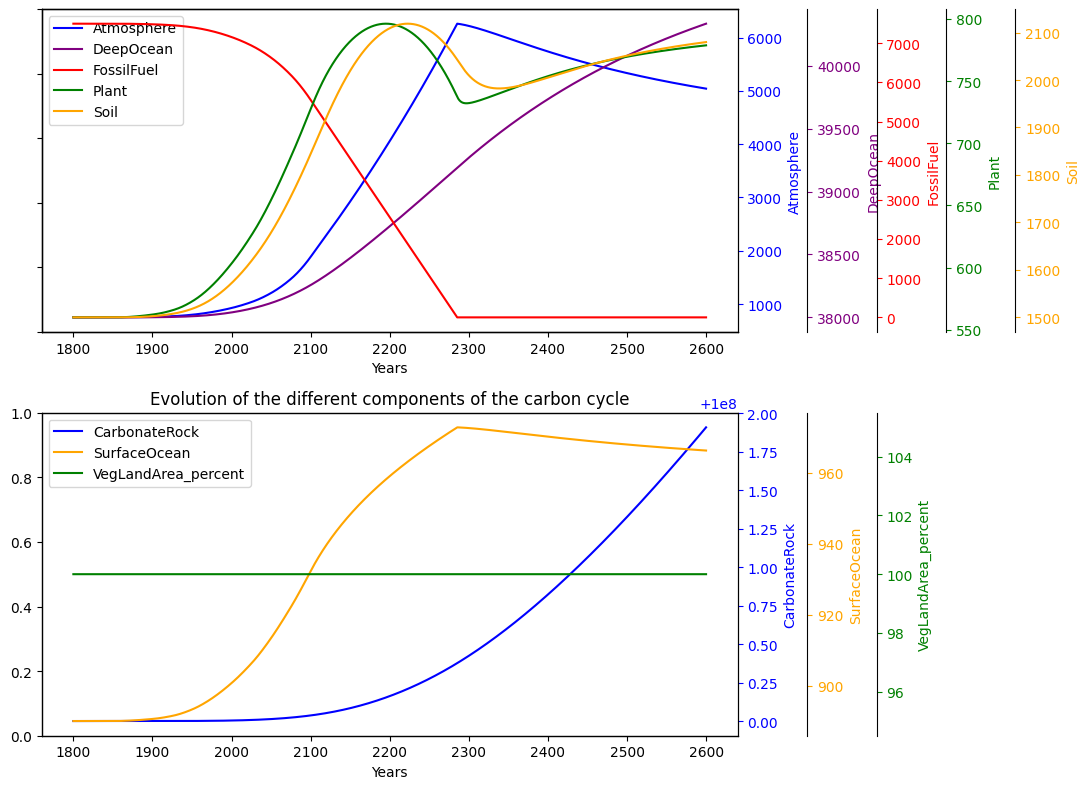

In [ ]:
plot_method(y_RK4,t)
plot_method1(y_RK4,t)

#### Stabilités et erreurs

In [ ]:
# pour plot plusieurs RK en partant des éléments de x0_l.
# x0_l est une liste de vecteur

def stabilite(n, x0_l):
    t0 = 1800
    T = 1000
    h = [T/n for i in range(0, n)]
    t = np.array([t0 + i * T/n for i in range(0, n)])
    y_l = []
    for x0 in x0_l:
        y = runge_kutta(derivative, t0, x0, c4, b4, A4, h)
        y_l.append(y)
    return np.array(y_l)

In [ ]:
# on perturbe un peu le vecteur initial
# variance = 1
# y_l = stabilite(1000 * 10, [(0.05 * np.diag(np.concatenate((np.random.normal(0, 1, 7), np.array([0])))) @ x0) + x0 for i in range(0,15)])

In [ ]:
def diff(y1, y2):
  return np.abs(y1-y2)

def diff_cumule(y1, y2):
    diff_y = diff(y1, y2)
    return np.array([[sum(diff_y[:i, j]) for j in range(0, len(y1[0]))] for i in range(len(y1))])

##### Erreur en fonction de la méthode (RK1, RK2, RK4)

In [ ]:
n = T * 150
h1 = [T/n for i in range(0, n)]
t = np.array([t0 + i * T/n for i in range(0, n)])
N = 15
h2 = [N * T/n for i in range(0, n//N)]

y = runge_kutta(derivative, t0, x0, c4, b4, A4, h1) # tres précis = vrais résultats
y1 = y[::N]
y_RK4 = runge_kutta(derivative, t0, x0, c4, b4, A4, h2) #RK q=4
y_RK2 = runge_kutta(derivative, t0, x0, c2, b2, A2, h2) #RK q=2
y_RK1 = runge_kutta(derivative, t0, x0, c1, b1, A1, h2) #RK q=1

In [ ]:
diff_4 = diff(y1, y_RK4)
diff_2 = diff(y1, y_RK2)
diff_1 = diff(y1, y_RK1)
diff_2.shape, t[::N].shape
t_N=t[::N]

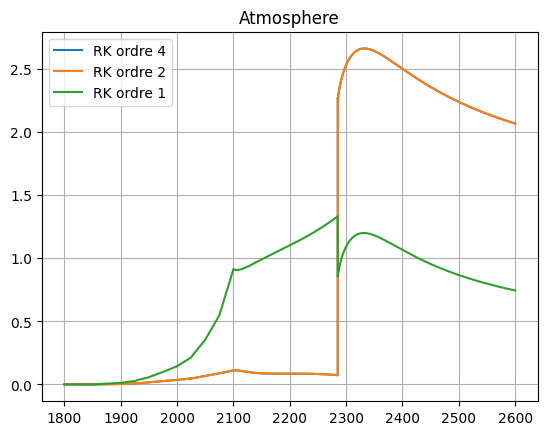

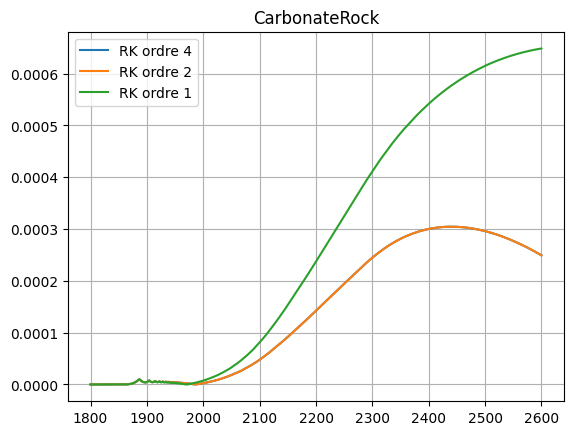

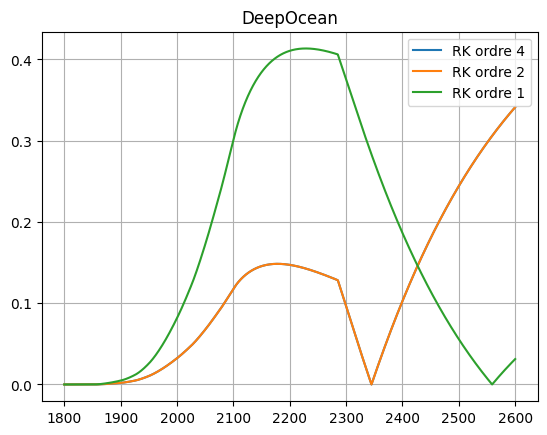

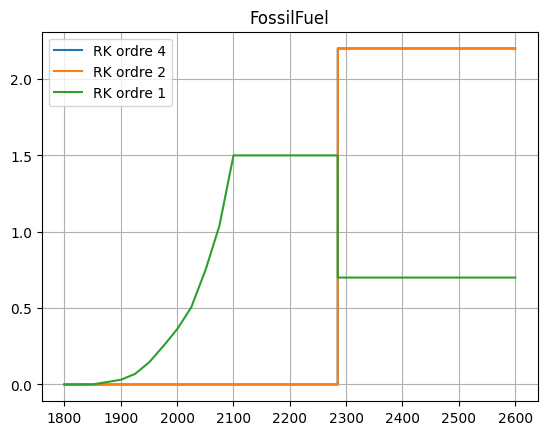

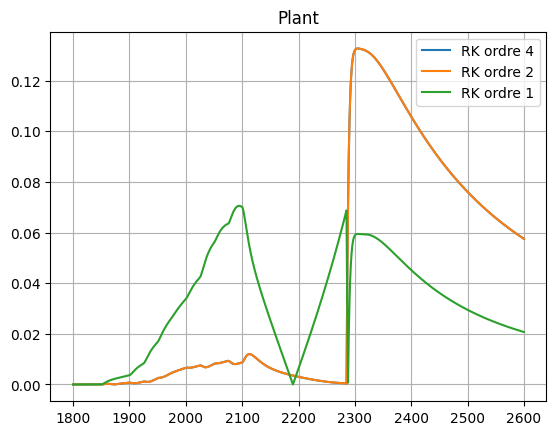

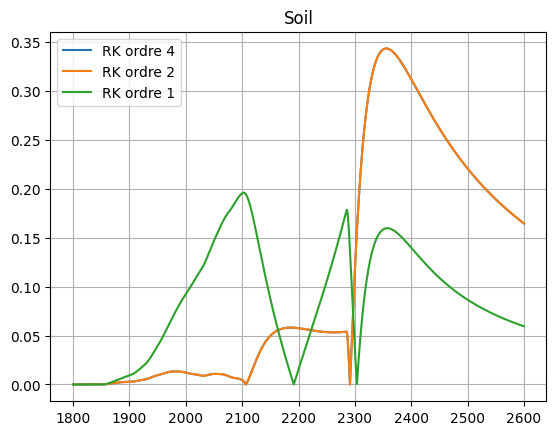

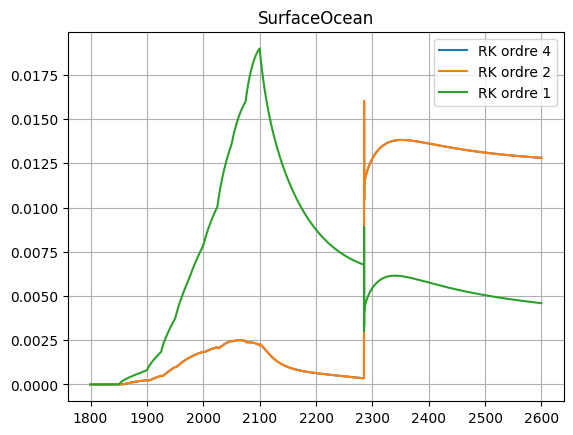

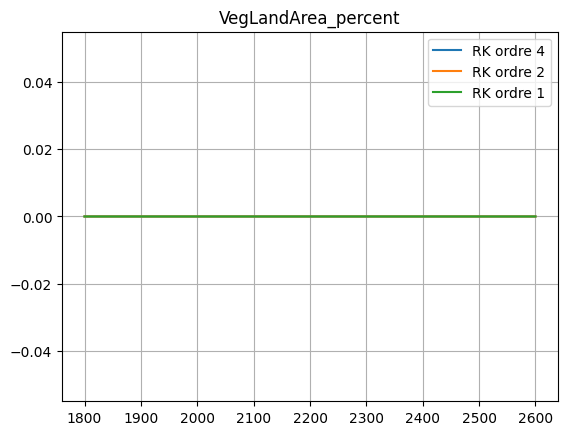

In [ ]:
# on observe l'erreur sur chaque composante pour chaque méthode
plot_runge_comp(np.array([diff_4, diff_2, diff_1]), t_N, label2 = ["RK ordre 4", "RK ordre 2", "RK ordre 1"]) # le RK 4 est sous le RK 2

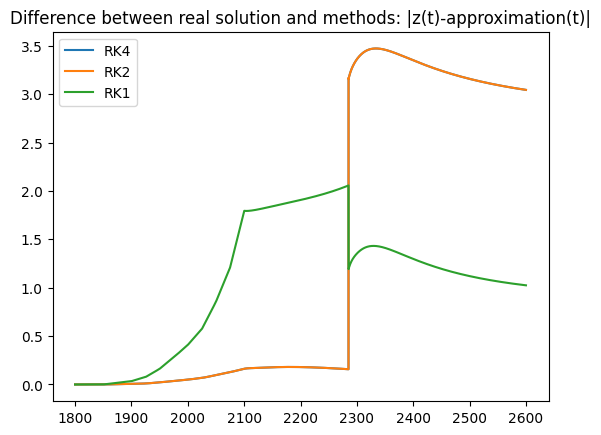

In [ ]:
plt.plot(t_N,[np.linalg.norm(diff_4[i,:]) for i in range(0,len(diff_4))])
plt.plot(t_N,[np.linalg.norm(diff_2[i,:]) for i in range(0,len(diff_2))])
plt.plot(t_N,[np.linalg.norm(diff_1[i,:]) for i in range(0,len(diff_1))])
plt.legend(["RK4","RK2","RK1"])
plt.title("Difference between real solution and methods: |z(t)-approximation(t)|") # on regarde la norme de l'erreur
plt.show()

##### Erreur en fonction du nombre de points par année

On regarde l'erreur quand on prend 150//2 ; 150//4 et 150//8 points par année, dans un premier temps composante par composante puis simplement la norme du vecteur erreur(t)

In [ ]:
h2 = [2 * T/n for i in range(0, n//2)]
h3 = [4 * T/n for i in range(0, n//4)]
h4 = [8 * T/n for i in range(0, n//8)]

y2 = runge_kutta(derivative, t0, x0, c4, b4, A4, h2)[::4]
y3 = runge_kutta(derivative, t0, x0, c4, b4, A4, h3)[::2]
y4 = runge_kutta(derivative, t0, x0, c4, b4, A4, h4)

diff_2 = diff(y[::8], y2)
diff_3 = diff(y[::8], y3)
diff_4 = diff(y[::8], y4)

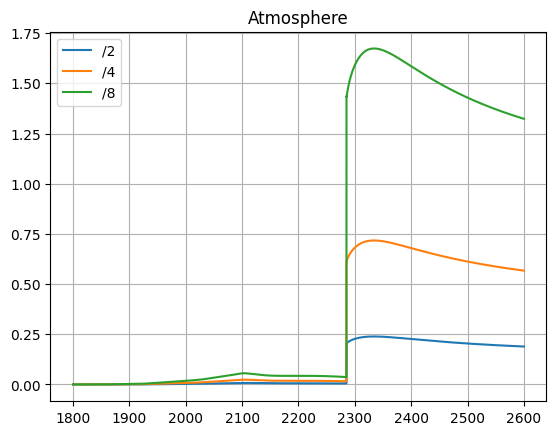

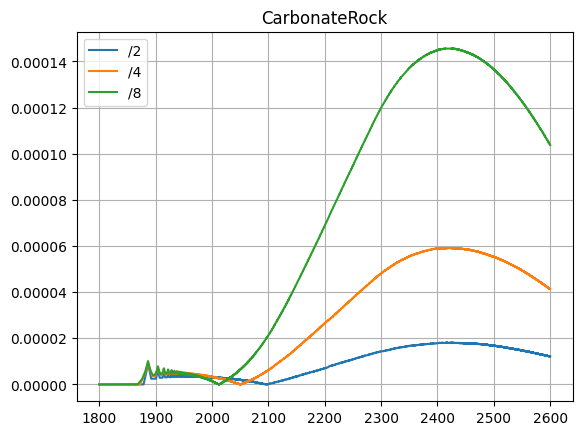

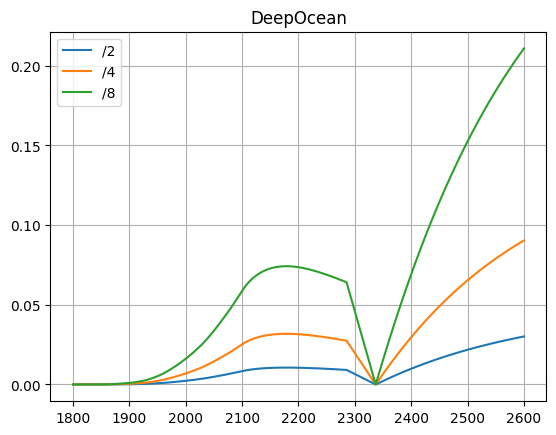

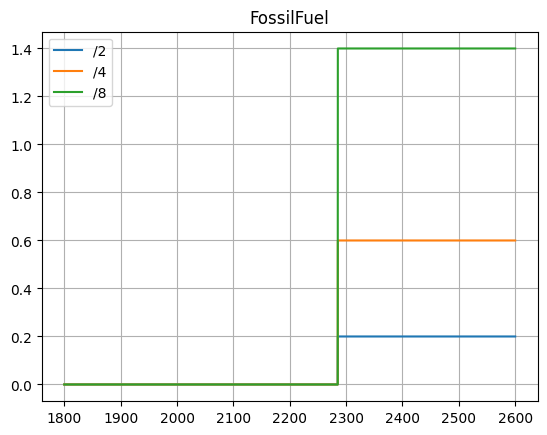

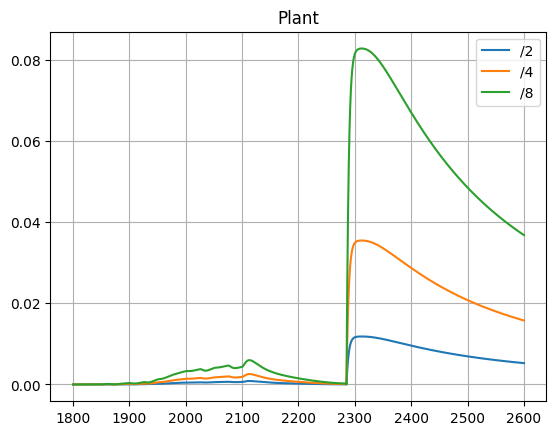

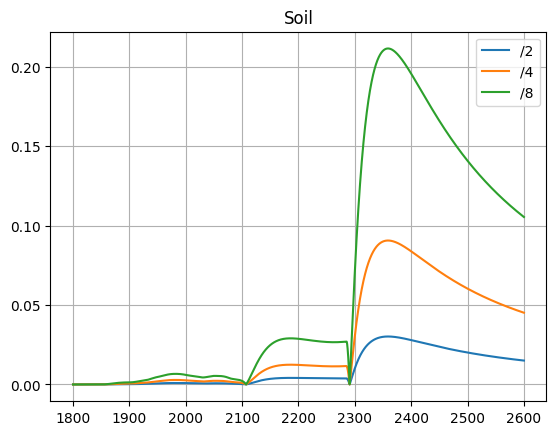

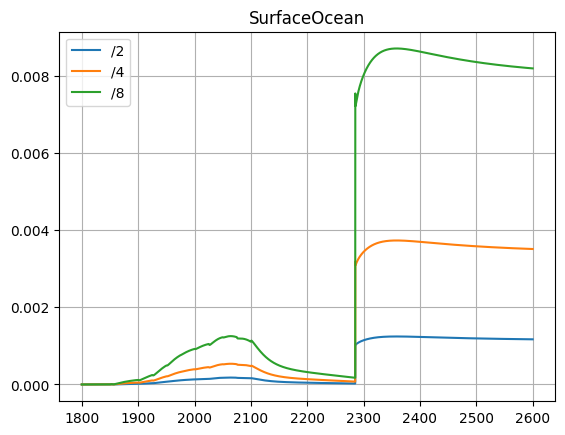

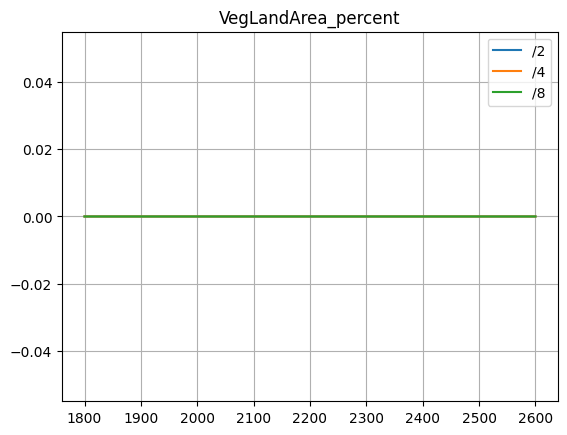

In [ ]:
plot_runge_comp(np.array([diff_2, diff_3, diff_4]), t[::8], label2 = ["/2", "/4", "/8"])

On regarde la norme de l'erreur

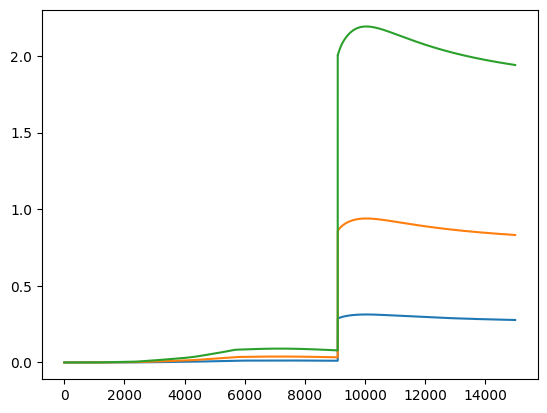

In [ ]:
plt.plot([np.linalg.norm(diff_2[i,:]) for i in range(0,len(diff_2))])
plt.plot([np.linalg.norm(diff_3[i,:]) for i in range(0,len(diff_3))])
plt.plot([np.linalg.norm(diff_4[i,:]) for i in range(0,len(diff_4))])
plt.show()

On observe le maximum de la norme de l'erreur en fonction du nombre de points par période

In [ ]:
K = 8
e = []
for j in range(1, K):
  print(j)
  hn = [(2**(j)) * T/n for i in range(0, n//int(2**(j)))]
  yn = runge_kutta(derivative, t0, x0, c4, b4, A4, hn)[::int(2**(K-j))]
  diff_n = diff(y[::int(2**K)], yn)
  e.append(max([np.linalg.norm(diff_n[i,:]) for i in range(0,len(diff_n))]))

1
2
3
4
5
6


<ipython-input-3-ae9aaa34946a>:25: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)


7


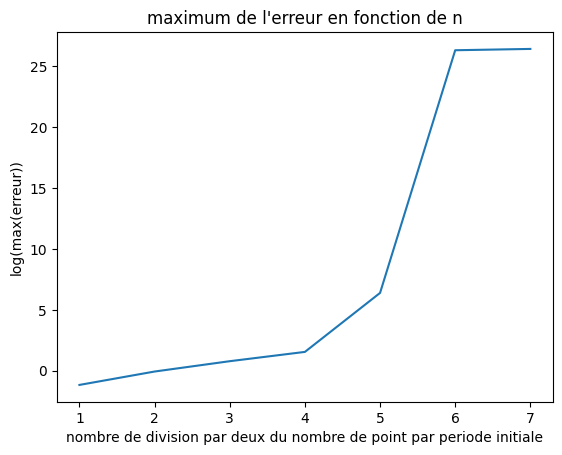

In [ ]:
plt.plot([i for i in range(1,K)], np.log(e))
plt.title("maximum de l'erreur en fonction de n")
plt.xlabel("nombre de division par deux du nombre de point par periode initiale")
plt.ylabel("log(max(erreur))")
plt.show()

##### Temps d'execution de chaque méthode en fonction du nombre de points par période.

<ipython-input-3-ae9aaa34946a>:25: RuntimeWarning: invalid value encountered in sqrt
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
<ipython-input-3-ae9aaa34946a>:17: RuntimeWarning: overflow encountered in scalar multiply
  return ((60 - GlobalTemp) * (GlobalTemp + 15)) / (((60 + 15) / 2) ** (2))/.96
<ipython-input-3-ae9aaa34946a>:13: RuntimeWarning: invalid value encountered in scalar divide
  return 1.5 * ((AtmCO2) - 40) / ((AtmCO2) + 80)
<ipython-input-3-ae9aaa34946a>:25: RuntimeWarning: overflow encountered in scalar power
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)
<ipython-input-3-ae9aaa34946a>:25: RuntimeWarning: invalid value encountered in scalar divide
  return(SurfCConc-(np.sqrt(SurfCConc**2-Alk*(2*SurfCConc-Alk)*(1-4*Kcarb))))/(1-4*Kcarb)


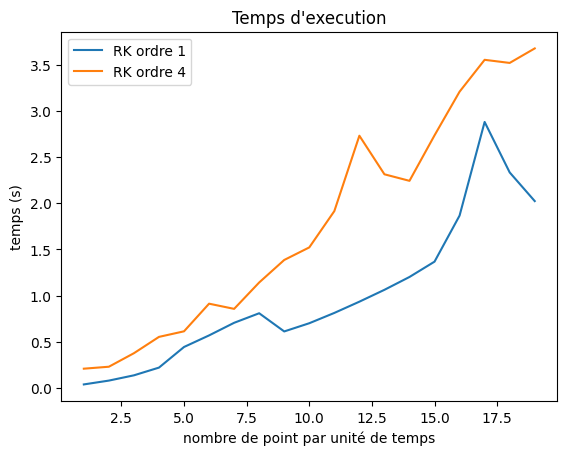

In [ ]:
def perf_rk(n, T, c, b, A):
    h = [T/n for i in range(0, n)]
    t = np.array([t0 + i * T/n for i in range(0, n)])
    t_deb = time.time()
    y = runge_kutta(derivative, t0, x0, c, b, A, h)
    t_fin = time.time()
    return t_fin - t_deb

l4 = [perf_rk(1000 * i, 1000, c4, b4, A4) for i in range(1, 20)]
l1 = [perf_rk(1000 * i, 1000, np.array([0]), np.array([1]), np.array([[0]])) for i in range(1, 20)]

plt.plot([i for i in range(1, len(l1) +1)], l1, label = "RK ordre 1")
plt.plot([i for i in range(1, len(l4) +1)], l4, label = "RK ordre 4")
plt.legend()
plt.title("Temps d'execution")
plt.ylabel("temps (s)")
plt.xlabel("nombre de point par unité de temps")
plt.show()


La fonction suivante calcule une solution approchée du problème, qu'on note $(y_n)$. Ensuite, elle compare pour chaque $n$ $y_n$ et le point qui serait atteint par une solution z (parfaite) vérifiant $z(t_{n-1}) = y_{n-1}$. Elle permet donc d'observer l'erreur créée par la n-ième itération.  

In [ ]:
# erreur génerer à une ittération de Runge-Kutta en partant y_n à chaque itération sur n
def e_generate(c, b, A, h, N=5):
    h1 = np.array([N * eh for eh in h[::N]])

    y = runge_kutta(derivative, t0, x0, c, b, A, h1)
    e = np.zeros(np.shape(y))

    for i in range(1, len(y)-1):
        y2 = runge_kutta(derivative, t0 + sum(h1[:i]), y[i-1], c4, b4, A4, h[i*N : (i+1)*N + 1])
        e[i, :] = y[i] - y2[N]
    return e


In [ ]:
N = 25
h = [T/n for i in range(0, n)]
t = np.array([t0 + i * T/n for i in range(0, n)])

e = e_generate(c4, b4, A4, h, N = N)

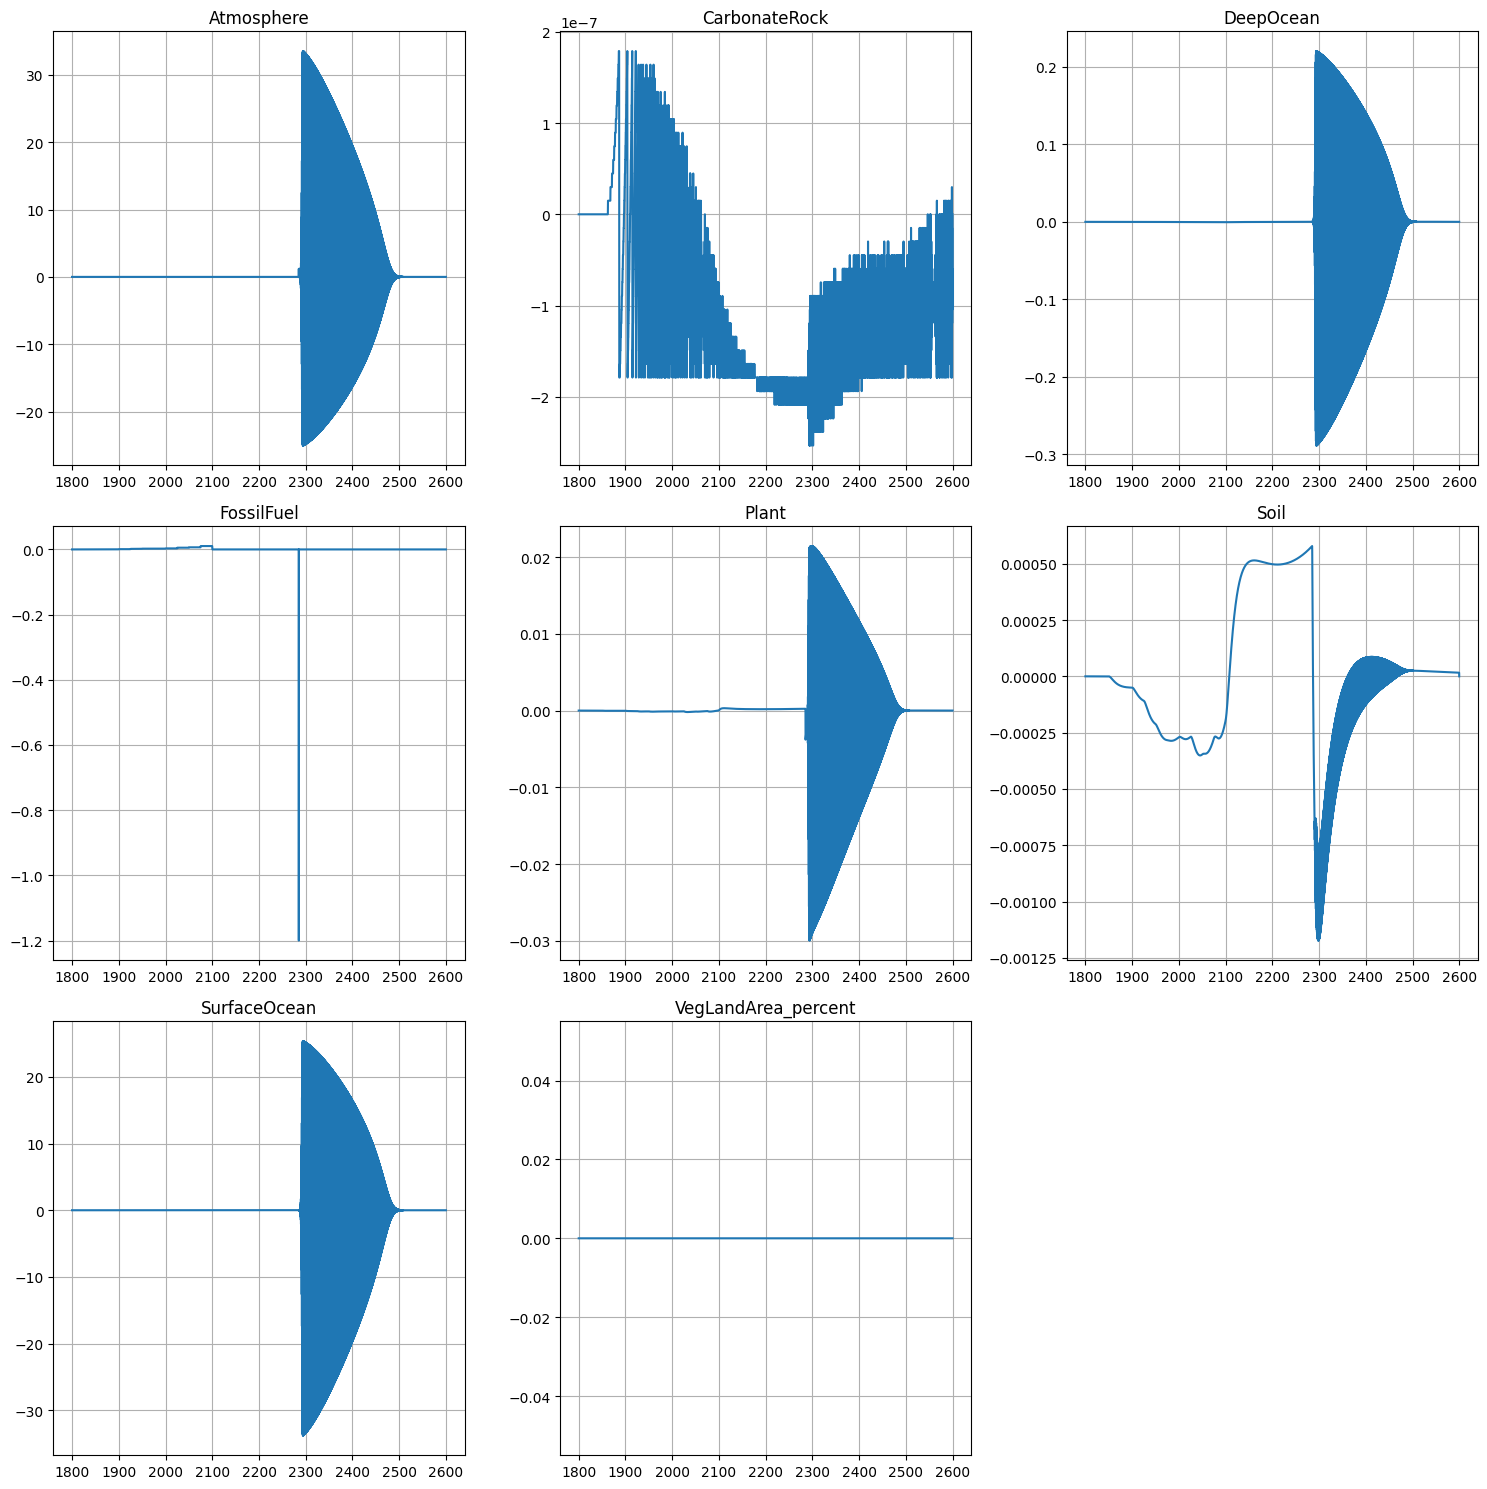

In [ ]:
plot_method(e, t[::N])

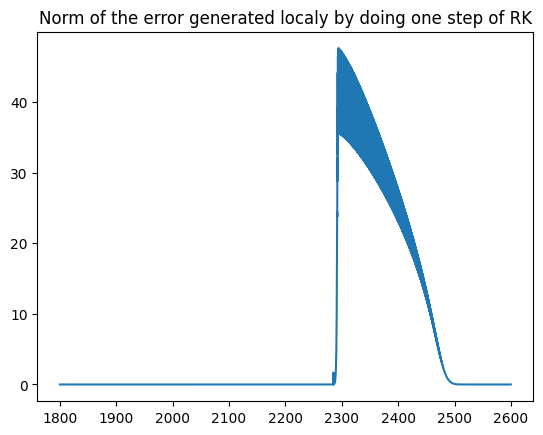

In [ ]:
plt.plot(t[::N],[np.linalg.norm(e[i,:]) for i in range(0,len(e))])
plt.title("Norm of the error generated localy by doing one step of RK")
plt.show()

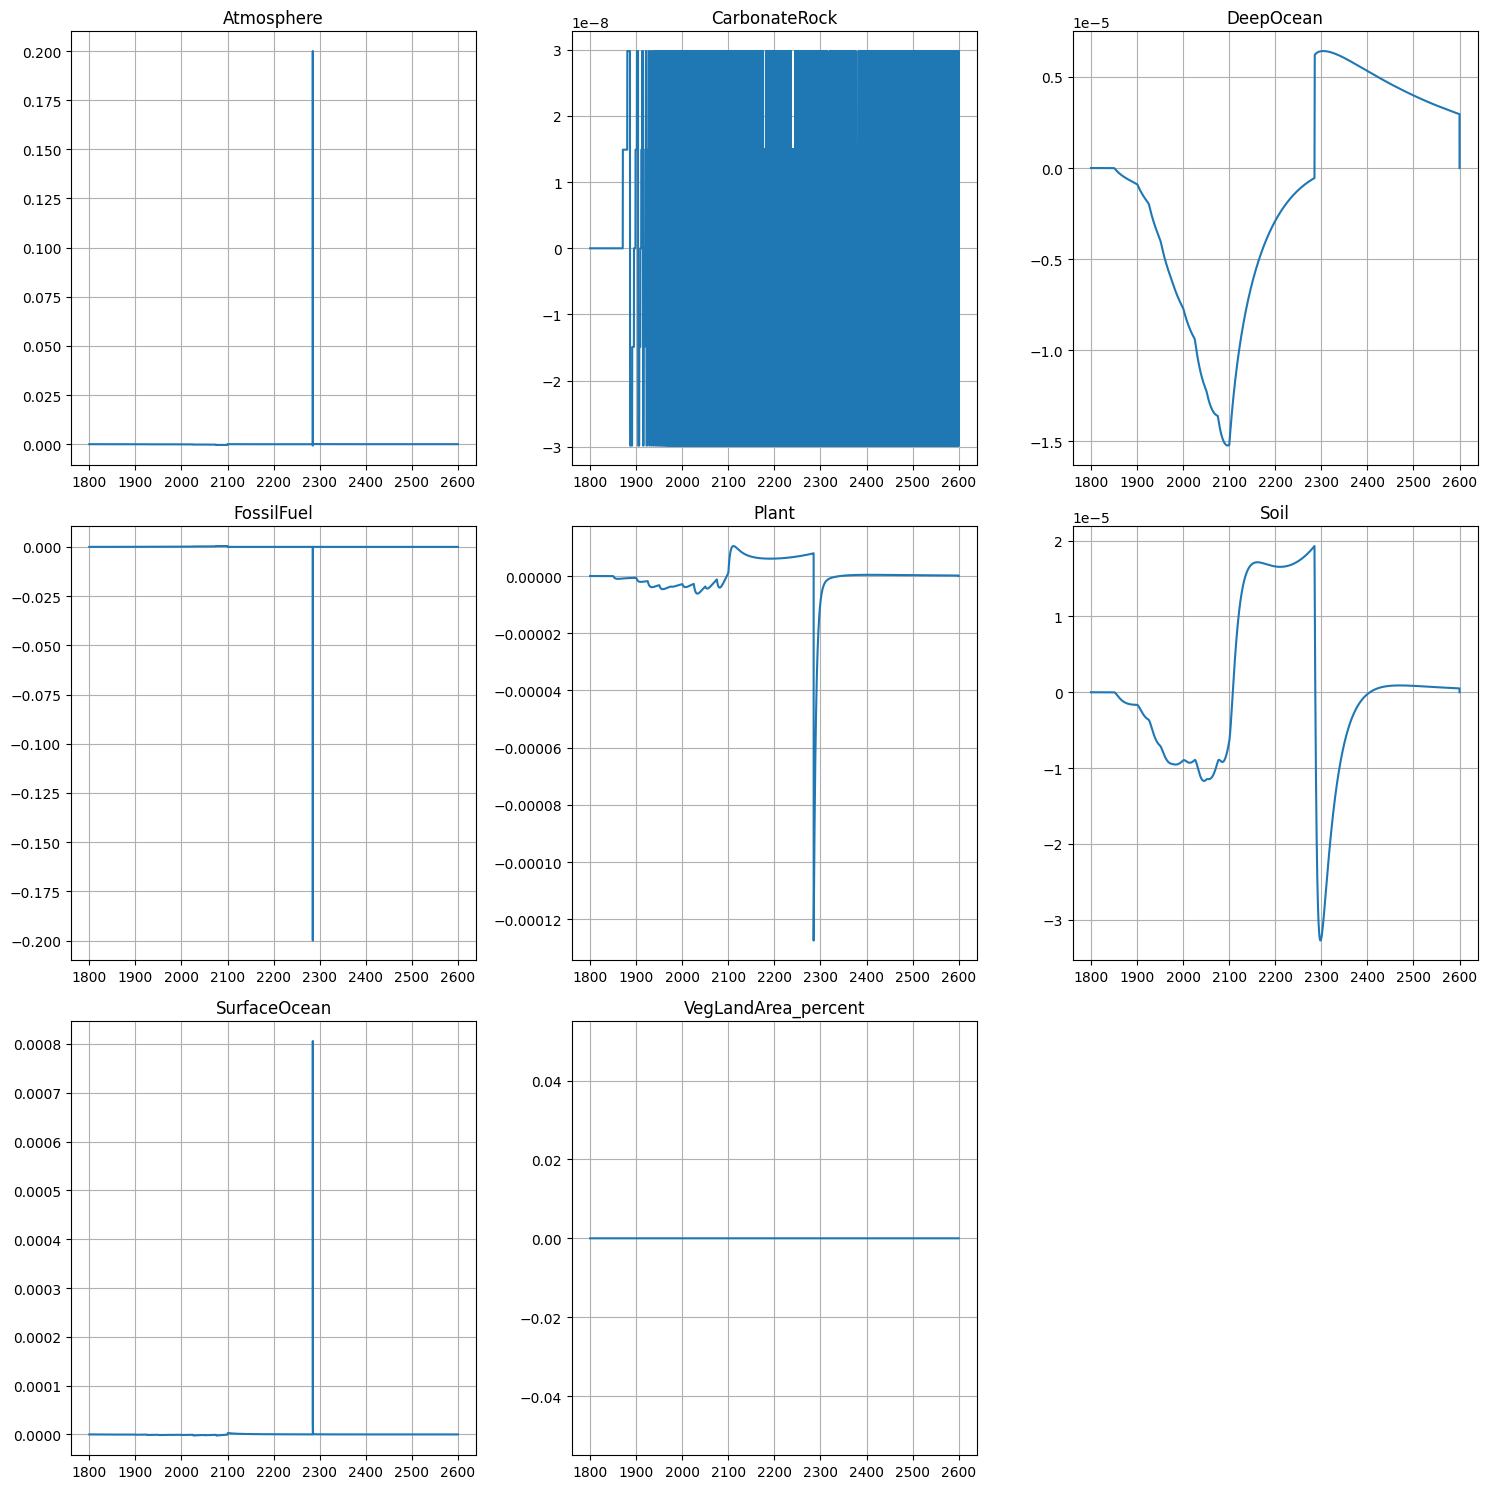

In [ ]:
N=5
e = e_generate(c4, b4, A4, h, N = N) # petit pas => erreur de consistance bien plus faible (comme prévu)
plot_method(e, t[::N])

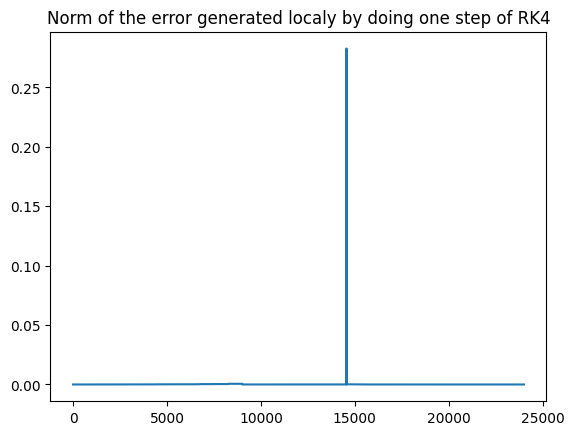

In [ ]:
plt.plot([np.linalg.norm(e[i,:]) for i in range(0,len(e))])
plt.title("Norm of the error generated localy by doing one step of RK4")
plt.show()

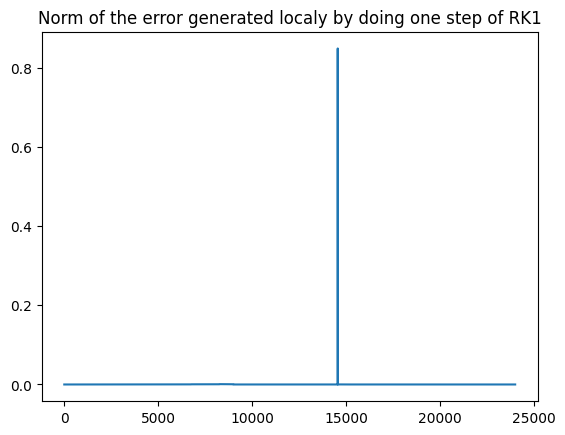

In [ ]:
e = e_generate(c1, b1, A1, h, N = 5) # petit pas => erreur de consistance bien plus faible (comme prévu)
plt.plot([np.linalg.norm(e[i,:]) for i in range(0,len(e))])
plt.title("Norm of the error generated localy by doing one step of RK1")
plt.show()

##### Stabilité

In [ ]:
# on perturbe chaque itération de RK en ajoutant un terme e_pert[n] et on retourne la fonction perturbée et non perturbée
def runge_kutta_perturbe(f, t0, y0, c, b, A, h, e_pert):
  N = len(h)
  t = np.array([t0 + sum(h[:i]) for i in range(0, N)])
  y1 = np.zeros((N + 1, len(y0)))
  y2 = np.zeros((N + 1, len(y0)))
  y1[0,:] = y0
  y2[0,:] = y0
  for j in range(0, N):
    y1[j+1, :] = runge_kutta_aux(f, t[j], y1[j,:], c, b, A, h[j]) + e_pert[j, :]
    y2[j+1, :] = runge_kutta_aux(f, t[j], y2[j,:], c, b, A, h[j])
  return y1[:-1], y2[:-1]

In [ ]:
epsilon = np.random.normal(0, 0.1, (len(h),8))
h9 = [10 * T/n for i in range(0, n//10)]
y1, y2 = runge_kutta_perturbe(derivative, t0, x0, c4, b4, A4, h9, epsilon)

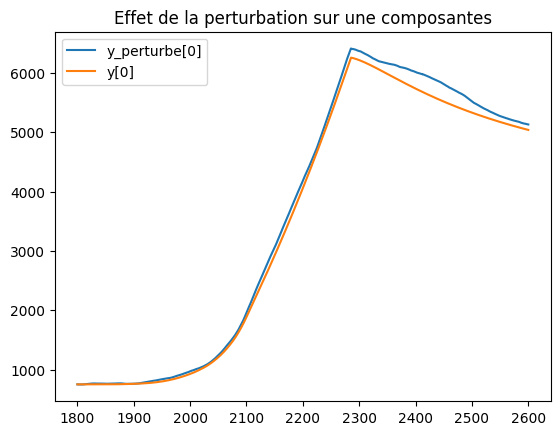

In [ ]:
plt.plot(t[::10], y1[:, 0], label = "y_perturbe[0]")
plt.plot(t[::10], y2[:, 0], label = "y[0]")
plt.title("Effet de la perturbation sur une composantes")
plt.legend()
plt.show()

In [ ]:
e = y1 - y2
somme = sum([np.linalg.norm(epsilon[i,:]) for i in range(0, len(epsilon))])
max_e = np.max([np.linalg.norm(e[i,:]) for i in range(0, len(e))])
max_e/somme

0.011985569369193524

In [ ]:
# on cherche a obtenir la constante S en réalisant un grand nombre de fois "runge_kutta_perturbe" puis en divisant par la somme des erreurs
def stability_test():
  l = []
  for i in range(0, 25):
    print(i)
    epsilon = np.random.normal(0, 1, (len(h9),8))
    y1, y2 = runge_kutta_perturbe(derivative, t0, x0, c4, b4, A4, h9, epsilon)
    e = y1 - y2
    somme = sum([np.linalg.norm(epsilon[i,:]) for i in range(0, len(epsilon))])
    max_e = np.max([np.linalg.norm(e[i,:]) for i in range(0, len(e))])
    l.append(max_e/somme)
  return l

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-75-f58dacee1e91>, line 3)

In [ ]:
l = stability_test()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [ ]:
print("Max : " + str(max(l)))
print("Mean : " + str(np.mean(l)))
print("Var : " + str(np.std(l)))

Max : 0.20549020694871434
Mean : 0.11468413407887101
Var : 0.04145937700262542


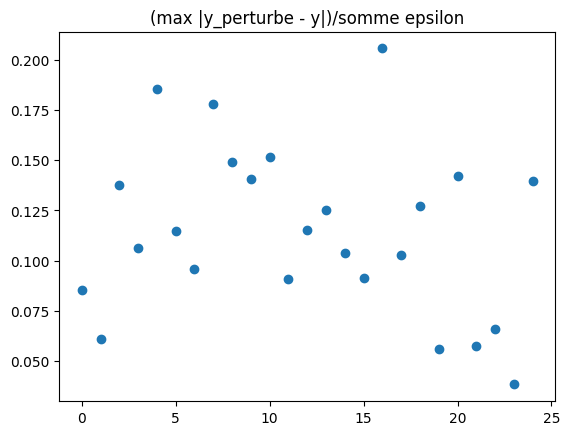

In [ ]:
plt.plot(l, "o")
plt.ylabel("")
plt.title("(max |y_perturbe - y|)/somme epsilon")
plt.show()